In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/pj/jqxzlr5d7bvc9htm5rrxf8th0000gs/T/ipykernel_43643/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [37]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.
most_recent_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

2017-08-23


<Axes: title={'center': 'Precipitation Over Time'}, xlabel='Date', ylabel='Precipitation (mm)'>

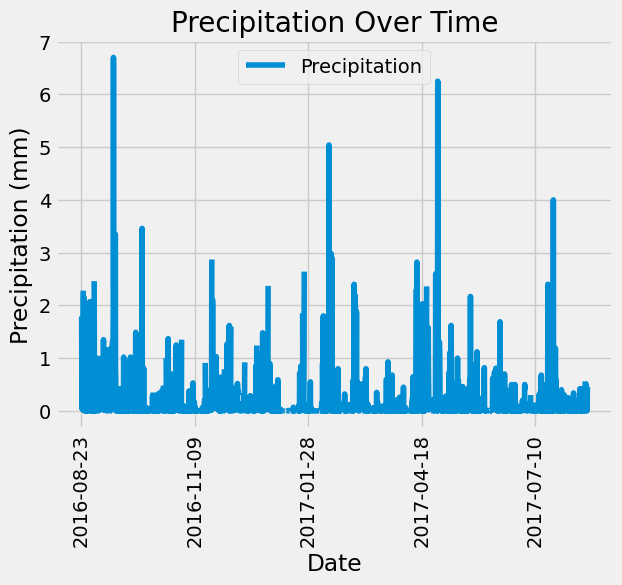

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
precipitation_df.head()

# Sort the dataframe by date
precipitation_df=precipitation_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="Date", y="Precipitation", xlabel="Date", ylabel="Precipitation (mm)", title="Precipitation Over Time", rot= 90)

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Station.station).count()
print(num_stations)

9


In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = func.count(Measurement.station)
active_stations = session.query(Measurement.station, station_counts).group_by(Measurement.station).order_by(station_counts.desc()).all()
active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Count'])
print(f"The station ids are listed below in descending order (greatest to smallest) of number of observations") 
display(active_stations_df)

most_active_station = active_stations_df.iloc[0]["Station"]
print(f"The most active station is {most_active_station}.")

The station ids are listed below in descending order (greatest to smallest) of number of observations


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


The most active station is USC00519281.


In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_temps = session.query(Measurement.tobs).where(Measurement.station == most_active_station).all()
most_active_station_temps_df = pd.DataFrame(most_active_station_temps, columns=['Temperature'])
display(most_active_station_temps_df.describe())

,Temperature
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


Text(0, 0.5, 'Frequency')

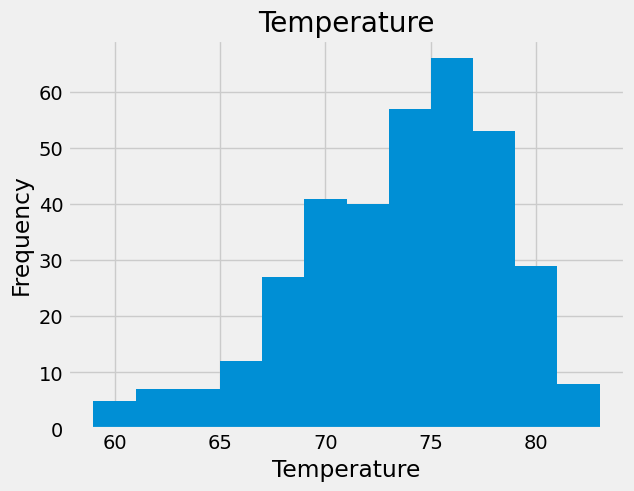

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_12mos_temps = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()
most_active_12mos_temps_df = pd.DataFrame(most_active_12mos_temps, columns=['Temperature'])
most_active_12mos_temps_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close Session

In [47]:
# Close Session
session.close()